In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay, f1_score
)
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from joblib import dump

def load_trimmed_sequences(data_dir, sequence_length=10):
    """
    Load pre-trimmed joint-coordinate CSVs and return:
      X: ndarray (n_samples, sequence_length, 39)
      y: ndarray (n_samples,) integer labels (1=Good, 0=Bad)
    """
    data_dir = Path(data_dir)
    paths = sorted(data_dir.glob("[GW]*_trimmed.csv"))

    X_list, y_list = [], []
    for p in paths:
        stem = p.stem
        if stem.startswith("G"):
            label = 1
        elif stem.startswith("W"):
            label = 0
        else:
            continue  # ignore unexpected files

        df = pd.read_csv(p)
        df = df.drop(columns=["FrameNo"], errors="ignore")
        seq = df.values
        F, D = seq.shape

        # sample or pad to fixed length
        if F >= sequence_length:
            idx = np.linspace(0, F - 1, sequence_length, dtype=int)
            proc_seq = seq[idx]
        else:
            pad = np.zeros((sequence_length - F, D), dtype=seq.dtype)
            proc_seq = np.vstack([seq, pad])

        X_list.append(proc_seq)
        y_list.append(label)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=int)
    return X, y


def build_dense(n_hidden_layers=2, param_budget=10_000, input_shape=(10, 39)):
    """
    Build and compile a Sequential dense model targeting ~param_budget parameters.

    Returns a tf.keras.Model.
    """
    D = np.prod(input_shape)
    L = n_hidden_layers

    # solve for hidden units per layer
    if L == 1:
        h = int((param_budget - 1) / (D + 1))
    else:
        a, b, c = (L-1), (D+L+1), (1 - param_budget)
        disc = b*b - 4*a*c
        h = int((-b + np.sqrt(disc)) / (2*a))
    h = max(1, h)

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        *[layers.Dense(h, activation="relu") for _ in range(L)],
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )
    return model


def cross_validate_dense(
    X, y,
    n_hidden_layers,
    param_budget=10_000,
    n_splits=5,
    epochs=50,
    batch_size=32,
    patience=10,
    input_shape=(10,39),
    random_state=42
):
    """
    Stratified K-Fold CV for the dense model.

    Returns:
      fold_metrics: list of (loss, accuracy, precision, recall, f1, auc)
      histories:    list of history.history dicts
      y_trues:      list of true-label arrays per fold
      y_preds:      list of predicted-label arrays per fold
      y_probs:      list of predicted-prob arrays per fold
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_metrics, histories = [], []
    y_trues, y_preds, y_probs = [], [], []

    for train_i, test_i in skf.split(X, y):
        # split and scale
        X_tr_raw, X_val_raw = X[train_i], X[test_i]
        y_tr, y_val         = y[train_i], y[test_i]
        flat_tr = X_tr_raw.reshape(-1, X.shape[-1])
        flat_val = X_val_raw.reshape(-1, X.shape[-1])
        scaler = StandardScaler().fit(flat_tr)
        X_tr = scaler.transform(flat_tr).reshape(X_tr_raw.shape)
        X_val = scaler.transform(flat_val).reshape(X_val_raw.shape)

        # build & fit
        model = build_dense(n_hidden_layers, param_budget, input_shape)
        es = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=epochs, batch_size=batch_size,
            verbose=0, callbacks=[es]
        )

        # predict & compute metrics
        y_prob = model.predict(X_val, verbose=0).ravel()
        y_pred = (y_prob >= 0.5).astype(int)
        f1 = f1_score(y_val, y_pred)

        loss, acc, prec, rec, auc_val = model.evaluate(X_val, y_val, verbose=0)
        fold_metrics.append((loss, acc, prec, rec, f1, auc_val))
        histories.append(history.history)

        y_trues.append(y_val)
        y_preds.append(y_pred)
        y_probs.append(y_prob)

    return fold_metrics, histories, y_trues, y_preds, y_probs


def plot_average_loss(histories, ax=None, title_prefix="Average Loss"):
    """Plot mean train & val loss over folds."""
    if ax is None: ax = plt.gca()
    min_e = min(len(h["loss"]) for h in histories)
    x = range(1, min_e+1)
    train = np.array([h["loss"][:min_e]     for h in histories]).mean(0)
    val   = np.array([h["val_loss"][:min_e] for h in histories]).mean(0)

    ax.plot(x, train, label="Train Loss")
    ax.plot(x, val,   label="Val Loss")
    ax.set(xlabel="Epoch", ylabel="Loss", title=f"{title_prefix} over {len(histories)} folds")
    ax.legend()


def plot_average_precision_recall(histories, ax=None, title_prefix="Avg Precision & Recall"):
    """Plot mean train & val precision/recall over folds."""
    if ax is None: ax = plt.gca()
    min_e = min(len(h["precision"]) for h in histories)
    x = range(1, min_e+1)
    tprec = np.array([h["precision"][:min_e]    for h in histories]).mean(0)
    vprec = np.array([h["val_precision"][:min_e] for h in histories]).mean(0)
    trec  = np.array([h["recall"][:min_e]       for h in histories]).mean(0)
    vrec  = np.array([h["val_recall"][:min_e]    for h in histories]).mean(0)

    ax.plot(x, tprec, label="Train Precision")
    ax.plot(x, vprec, label="Val Precision")
    ax.plot(x, trec,  label="Train Recall")
    ax.plot(x, vrec,  label="Val Recall")
    ax.set(xlabel="Epoch", ylabel="Metric", title=f"{title_prefix} over {len(histories)} folds")
    ax.legend()


def plot_aggregated_roc(y_trues, y_probs, ax=None, title="ROC Curve"):
    """Plot one ROC/AUC over all folds combined."""
    if ax is None: ax = plt.gca()
    y_true_all = np.concatenate(y_trues)
    y_prob_all = np.concatenate(y_probs)
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0,1], [0,1], "k--", label="Chance")
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title=title)
    ax.legend()


def plot_confusion_matrix(y_trues, y_preds, ax=None, labels=('Bad','Good'), title="Confusion Matrix"):
    """Plot aggregated confusion matrix over all folds."""
    if ax is None: ax = plt.gca()
    cms = [confusion_matrix(t, p) for t, p in zip(y_trues, y_preds)]
    total_cm = sum(cms)
    disp = ConfusionMatrixDisplay(total_cm, display_labels=labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(title)


def plot_cv_summary(histories, y_trues, y_preds, y_probs, depth, params):
    """
    2×2 summary: Loss, Precision/Recall, ROC & Confusion Matrix.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    plot_average_loss(histories,                ax=axs[0,0])
    plot_average_precision_recall(histories,    ax=axs[0,1])
    plot_aggregated_roc(y_trues, y_probs,       ax=axs[1,0])
    plot_confusion_matrix(y_trues, y_preds,     ax=axs[1,1])
    fig.suptitle(f"{depth}-layer model (~{params} params)", fontsize=16)
    plt.tight_layout()
    plt.show()


def print_results(fold_metrics, metric_names=None):
    """
    Print mean of each metric across folds.
    fold_metrics tuples: (loss, accuracy, precision, recall, f1, auc)
    """
    if metric_names is None:
        metric_names = ["bce_loss","accuracy","precision","recall","f1_score","auc"]
    mean_vals = {
        name: np.mean([fm[i] for fm in fold_metrics])
        for i, name in enumerate(metric_names)
    }
    print("Mean CV metrics:")
    for name in metric_names:
        print(f"  {name.title():<9}: {mean_vals[name]:.4f}")


X, y = load_trimmed_sequences("data/kinect_good_vs_bad_trimmed", sequence_length=10)

EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10

In [2]:
# Sweep over depths and compute mean CV accuracy
depths = range(1, 11)
mean_accuracies = []

for L in depths:
    fold_metrics, _, _, _, _ = cross_validate_dense(
        X, y,
        n_hidden_layers=L,
        param_budget=10_000,
        n_splits=5,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE
    )
    # accuracy is at index 1
    accuracies = [m[1] for m in fold_metrics]
    mean_accuracies.append(np.mean(accuracies))

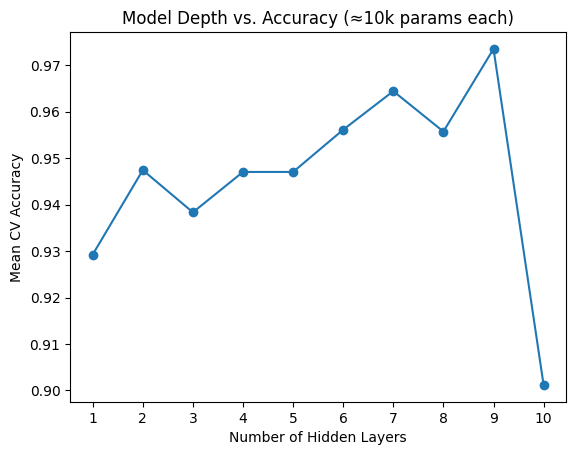

Best model depth: 9 hidden layers → mean CV accuracy = 0.9735


In [3]:
fig, ax = plt.subplots()
ax.plot(depths, mean_accuracies, '-o')
ax.set_xticks(depths)
ax.set_xlabel("Number of Hidden Layers")
ax.set_ylabel("Mean CV Accuracy")
ax.set_title("Model Depth vs. Accuracy (≈10k params each)")
plt.show()

# Find which depth gave the highest mean accuracy
best_idx = int(np.argmax(mean_accuracies))
best_depth = list(depths)[best_idx]
best_acc   = mean_accuracies[best_idx]

print(f"Best model depth: {best_depth} hidden layers → mean CV accuracy = {best_acc:.4f}")

In [4]:
LAYERS = best_depth
PARAMS = 10000

fold_metrics, histories, y_trues, y_preds, y_probs = cross_validate_dense(
    X, y,
    n_hidden_layers=LAYERS,
    param_budget=PARAMS,
    n_splits=10,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE
)

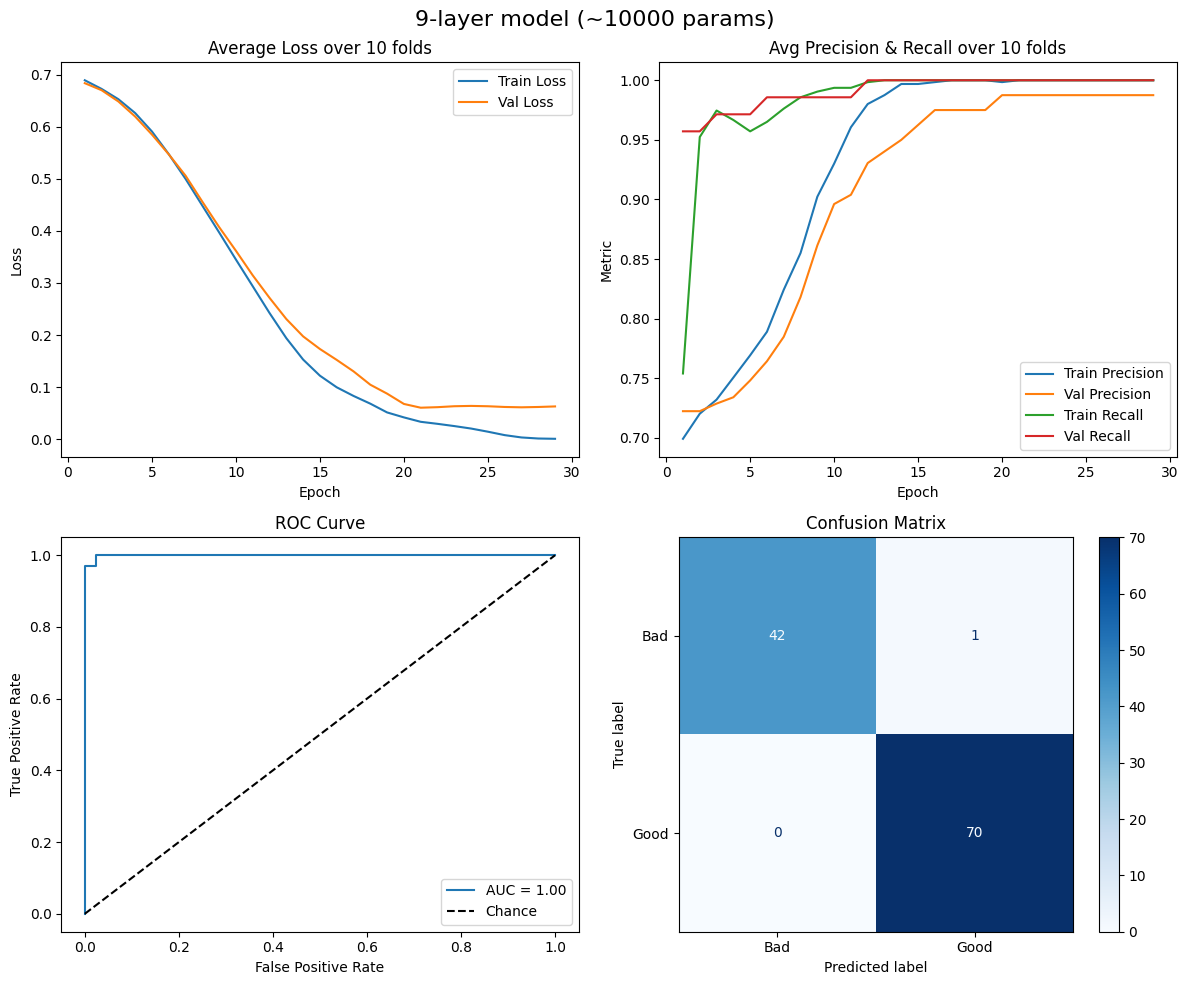

Mean CV metrics:
  Bce_Loss : 0.0272
  Accuracy : 0.9909
  Precision: 0.9875
  Recall   : 1.0000
  F1_Score : 0.9933
  Auc      : 0.9964


In [5]:
plot_cv_summary(histories, y_trues, y_preds, y_probs, LAYERS, PARAMS)
print_results(fold_metrics)

In [6]:
LAYERS = best_depth
PARAMS = 2000

fold_metrics, histories, y_trues, y_preds, y_probs = cross_validate_dense(
    X, y,
    n_hidden_layers=LAYERS,
    param_budget=PARAMS,
    n_splits=10,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE
)

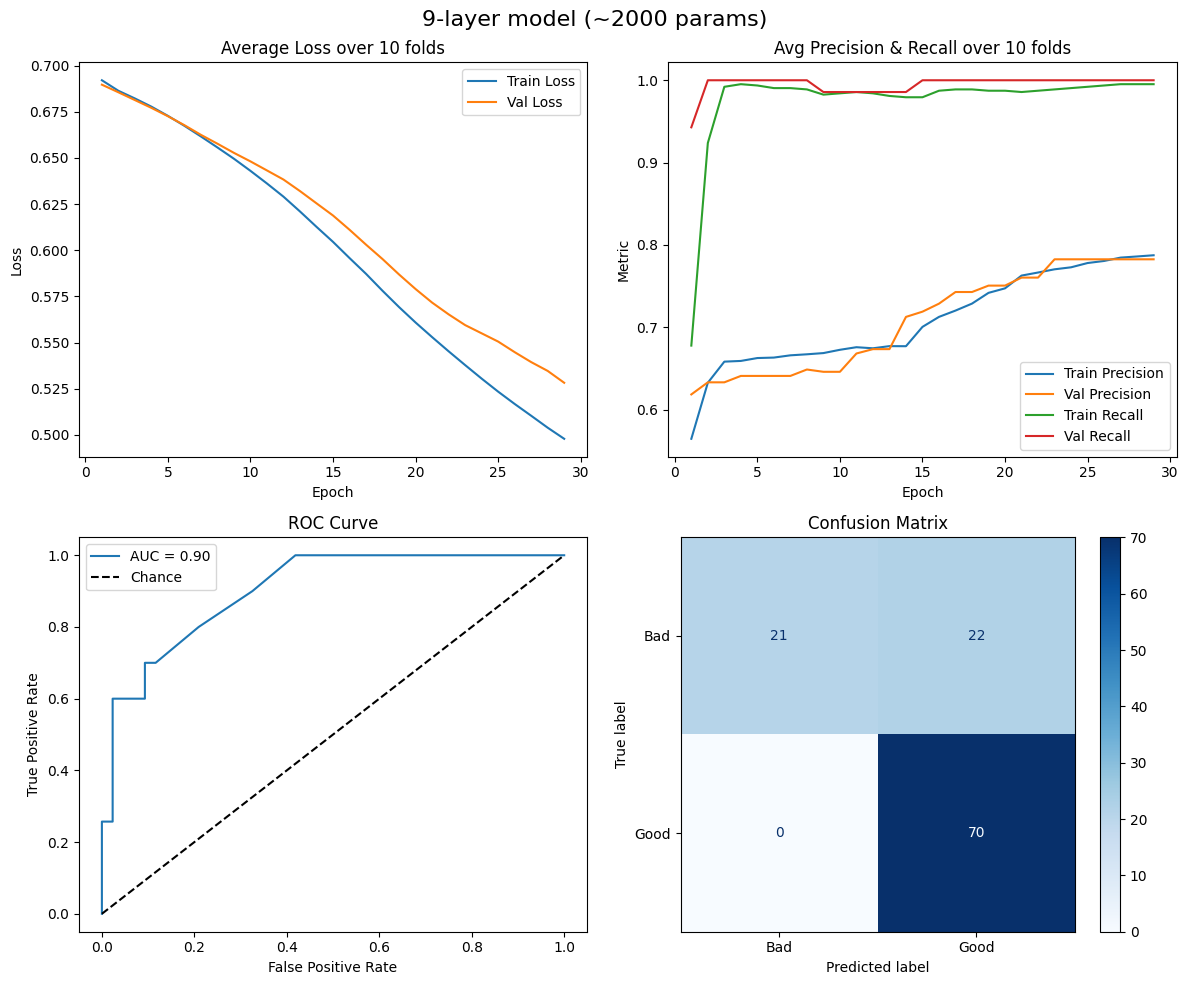

Mean CV metrics:
  Bce_Loss : 0.4432
  Accuracy : 0.8083
  Precision: 0.7967
  Recall   : 1.0000
  F1_Score : 0.8771
  Auc      : 0.8393


In [7]:
plot_cv_summary(histories, y_trues, y_preds, y_probs, LAYERS, PARAMS)
print_results(fold_metrics)

In [8]:
# ——— Final training on full dataset ———

# 1) Fit scaler on all of X
flat_all   = X.reshape(-1, X.shape[-1])
final_scaler = StandardScaler()
flat_scaled = final_scaler.fit_transform(flat_all)
X_scaled    = flat_scaled.reshape(X.shape)

# 2) Build final model
depth = best_depth
final_model = build_dense(
    n_hidden_layers=depth,
    param_budget=10_000,
    input_shape=(10, 39)
)

# 3) Train on the full, scaled dataset
final_model.fit(
    X_scaled, y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# 4) Save both model and scaler
final_model.save(os.path.join("models", "kinect_dense_good_vs_bad_model.keras"))
dump(final_scaler, os.path.join("models", "kinect_dense_good_vs_bad_scaler.pkl"))
print("Model and scaler saved successfully!")

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6561 - auc: 0.3457 - loss: 0.6894 - precision: 0.6561 - recall: 1.0000
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5634 - auc: 0.8749 - loss: 0.6637 - precision: 0.5634 - recall: 1.0000
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5999 - auc: 0.9663 - loss: 0.6161 - precision: 0.5999 - recall: 1.0000
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6305 - auc: 0.9859 - loss: 0.5481 - precision: 0.6284 - recall: 1.0000
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6607 - auc: 0.9886 - loss: 0.4796 - precision: 0.6443 - recall: 1.0000
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8134 - auc: 0.9958 - loss: 0.4004 - precision: 0.7725 - recall: 1.0000
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8463 - auc: 0.9974 - loss: 0.3734 - precision: 0.7985 - recall: 1.0000
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.